In [6]:
using Revise
using ITensors
using ITensorInfiniteMPS

using Statistics
using Plots
using LaTeXStrings

include("src/Fidelity.jl")
include("src/Entanglement_spectrum.jl");

In [55]:
function pitick(start, stop, denom; mode=:text)
    a = Int(cld(start, π/denom))
    b = Int(fld(stop, π/denom))
    tick = range(a*π/denom, b*π/denom; step=π/denom)
    ticklabel = piticklabel.((a:b) .// denom, Val(mode))
    tick, ticklabel
end

function piticklabel(x::Rational, ::Val{:text})
    iszero(x) && return "0"
    S = x < 0 ? "-" : ""
    n, d = abs(numerator(x)), denominator(x)
    N = n == 1 ? "" : repr(n)
    d == 1 && return S * N * "π"
    S * N * "π/" * repr(d)
end

function piticklabel(x::Rational, ::Val{:latex})
    iszero(x) && return L"0"
    S = x < 0 ? "-" : ""
    n, d = abs(numerator(x)), denominator(x)
    N = n == 1 ? "" : repr(n)
    d == 1 && return L"%$S%$N\pi"
    L"%$S\frac{%$N\pi}{%$d}"
end

piticklabel (generic function with 2 methods)

## Parameters to selects the files

In [56]:
# Root Pattern 
setRP = [[2,1,2,1]]

#Length in x-direction 
Lmin = 17.1 
Lmax = 17.1
Nstep = 1

#Angle parameter
θmin = 0
θmax = 2pi
Nθ = 20

#Bond dimension
χmax = 1024
χ = 1024

#Type of interaction 
typeInt = "2b_3b"

setL = LinRange(Lmin, Lmax, Nstep)
setθ = LinRange(θmin, θmax, Nθ)


println("
Parameters are : \n
L_min = $Lmin,
L_max = $Lmax,
step = $(step(setL)),
##########\n
θ_min = $θmin
θ_max = $θmax
dθ = $(step(setθ))
##########\n
χ max = $χmax
χ = $χ
")


Parameters are : 

L_min = 17.1,
L_max = 17.1,
step = 0.0,
##########

θ_min = 0
θ_max = 6.283185307179586
dθ = 0.3306939635357677
##########

χ max = 1024
χ = 1024



### Loading data

In [57]:
function LoadData(RootPattern::Vector{Int64}, setMeasure::LinRange{Float64, Int64}, FixParam::Float64, χmax::Int64, χ::Int64, type::String, measure::String; maxIters=100, noise=0.0)
    DictR = Dict()
    path = "Data/TransitionInfiniteCylinder/$(type)/"

    
    setE = []
    setPsi = Array{InfiniteCanonicalMPS}(undef, length(setMeasure))
    setErr =[]
    setEntr =[]
    
    for (ind, Meas) in enumerate(setMeasure)
        front = "rp$(RootPattern_to_string(RootPattern))_chiMax$(χmax)_"
        midName  = measure == "DT" ?  "Ly$(round(Meas, digits=5))_theta$(round(FixParam, digits=5))" : "Ly$(round(FixParam, digits=5))_theta$(round(Meas, digits=5))"
        endName = "_maxiters$(maxIters)_chi$(χ)_alpha$(noise).jld2"
        
        openName = path*front*midName*endName
        
        el = measure == "DT" ? "L" : "θ" 
        println("Loading $el = $(round(Meas, digits=5))")
        flush(stdout)
            
        jldopen(openName, "r") do file
            setPsi[ind] = file["dmrgStruct"].ψ
            append!(setE, file["energies"][end])
            append!(setErr,file["errors"])
            append!(setEntr, file["entropies"][end])
        end
    end
    
    DictR["Psi"] = setPsi
    DictR["Energy"] = setE
    DictR["Errors"] = setErr
    DictR["Entropy"] = setEntr

    return DictR
end;


In [58]:
setData = Array{Dict}(undef, length(setRP))

for (ind, rp) in enumerate(setRP)
    if Nstep != 1
        setData[ind] = LoadData(rp, setL, setθ[1], χmax, χ, typeInt, "DT")
    else
        
        setData[ind] = LoadData(rp, setθ, setL[1], χmax, χ, typeInt, "PP")
    end

    println("Sucessfuly load the data")
end

Loading θ = 0.0


Loading θ = 0.33069


Loading θ = 0.66139


Loading θ = 0.99208


Loading θ = 1.32278


Loading θ = 1.65347


Loading θ = 1.98416


Loading θ = 2.31486


Loading θ = 2.64555


Loading θ = 2.97625


Loading θ = 3.30694


Loading θ = 3.63763


Loading θ = 3.96833


Loading θ = 4.29902


Loading θ = 4.62972


Loading θ = 4.96041


Loading θ = 5.2911


Loading θ = 5.6218


Loading θ = 5.95249


Loading θ = 6.28319


Sucessfuly load the data


## Entanglement spectrum

In [59]:
function plot_entanglement_spectrum(psi, Meas, L)
  l = @layout [a b; c d]
  D = compute_entanglement_spectrum(psi)
  p = []
  
  c = reverse(palette(:rainbow))

  for i=1:4

  N=0
  if i == 1
    N = 2
  elseif i == 2
    N = 4
  elseif i==3 
    N = 2
  end 

  E = Sector_Entanglement_Spectrum(D[i], N)

  push!(p, scatter(E["K"], E["Eta"], marker=:hline, markersize=5, linewidth=4, color=c[i], title="sector $(i-1)", primary=false, xlabel=L"$K$", ylabel=L"$\eta$", ylims=(0,10)))
  end 
  
  fig = plot(p..., layout=l, title=L"$\theta$"*"= $(round(Meas, digits=3))")

  display(fig)

  namesave = "FiguresNew/EntSpec_Ly$(L)_chi$(χ)_theta$(Meas)"
  
  Plots.png(fig, namesave)
  Plots.pdf(fig, namesave)

end;

In [60]:
function plotAllEntPhase()
    setPsi = setData[1]["Psi"]
    for (ind, θ) in enumerate(setθ)
        plot_entanglement_spectrum(setPsi[ind], θ, Lmin)
    end
end;

function plotAllEntLength()
    setPsi = setData["Psi"]
    for (ind, L) in enumerate(setL)
        plot_entanglement_spectrum(setPsi[ind], L)
    end
end;

function plotReprPhase(setIndex, L::Float64)
    setPsi = setData[1]["Psi"]
    for ind in setIndex
        plot_entanglement_spectrum(setPsi[ind], setθ[ind], L)
    end
end;
  

plotReprPhase (generic function with 1 method)

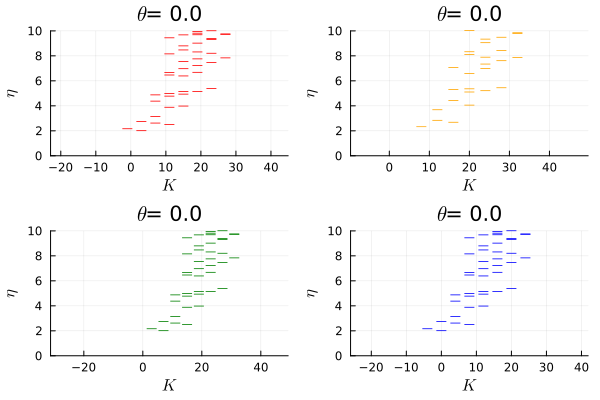

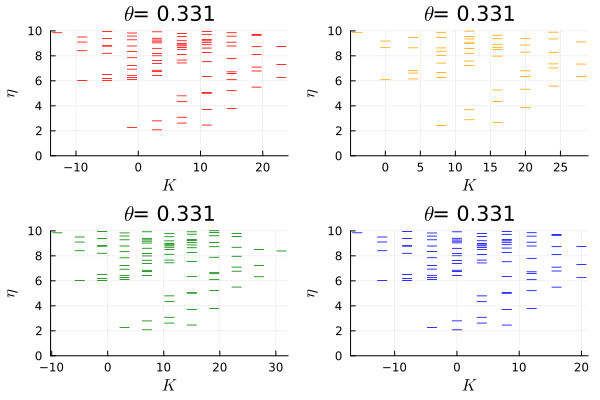

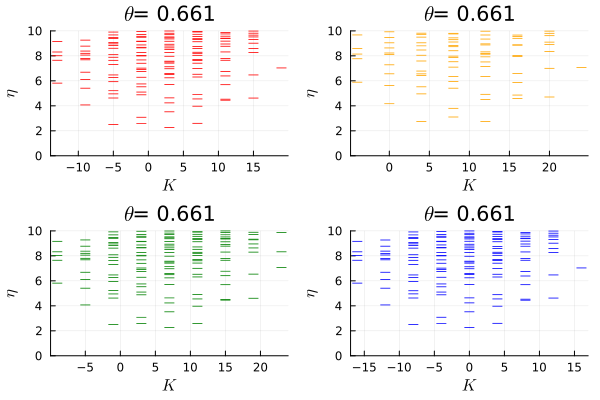

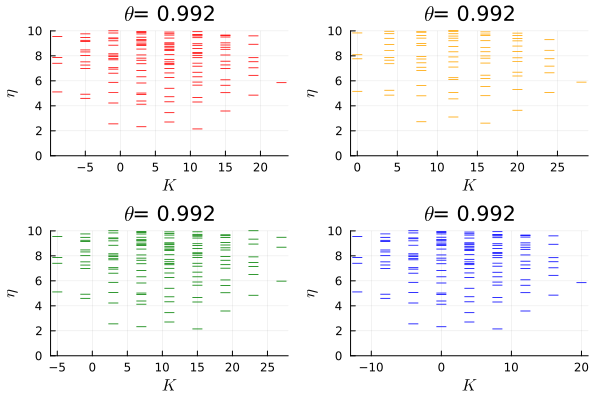

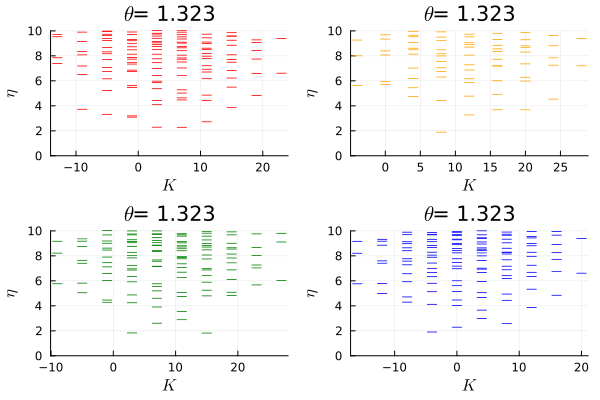

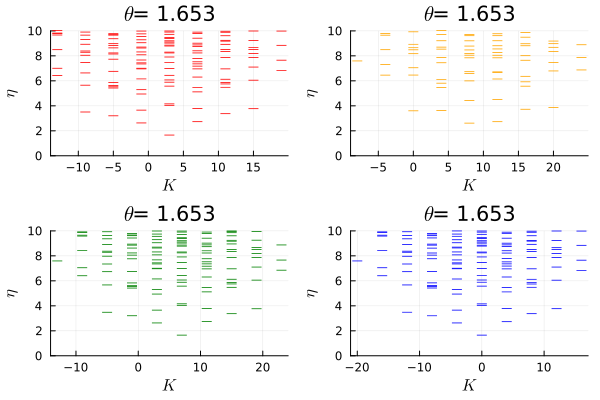

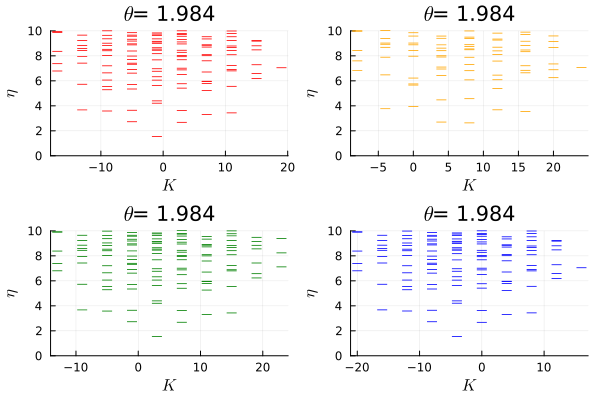

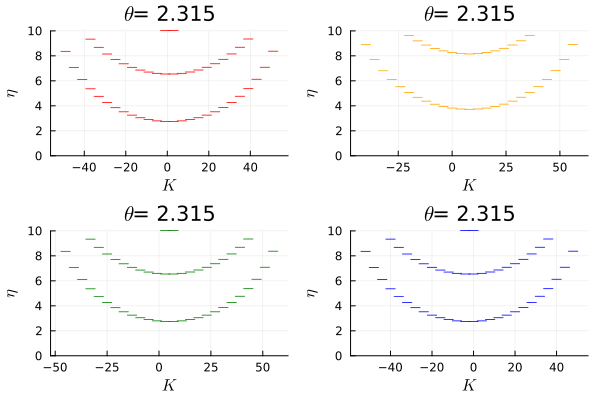

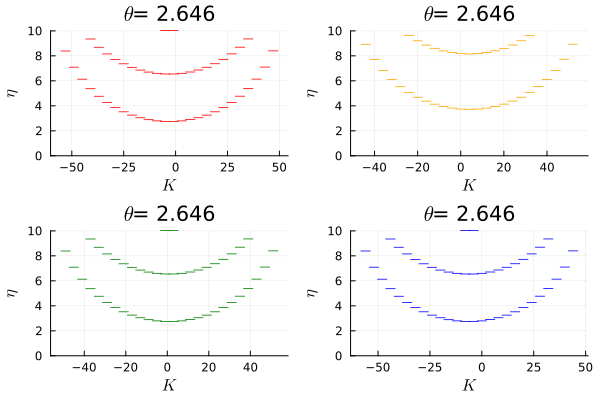

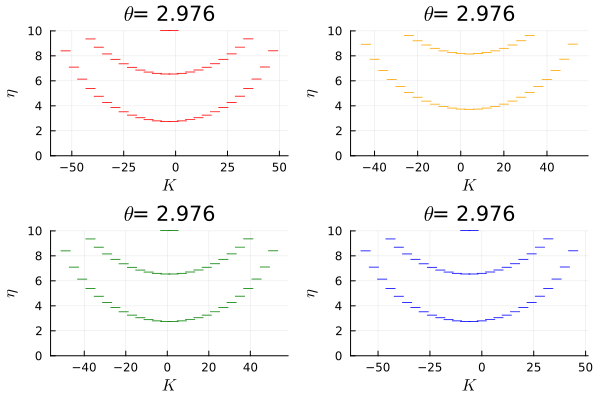

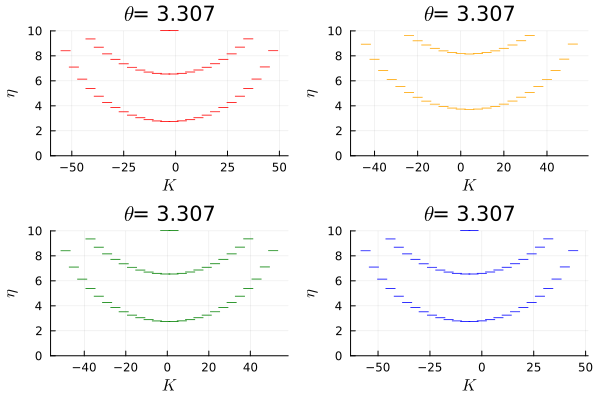

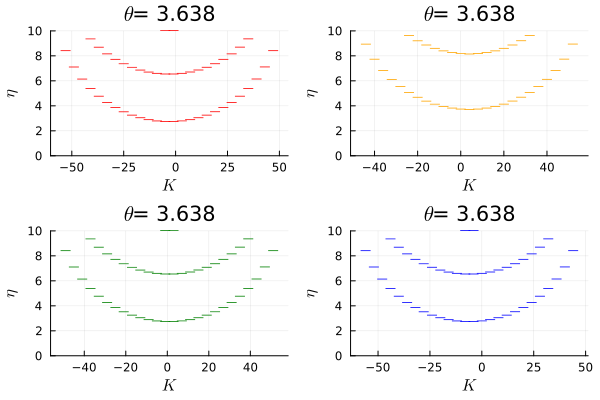

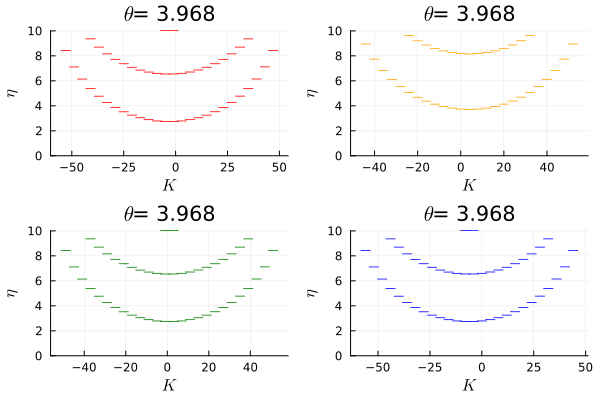

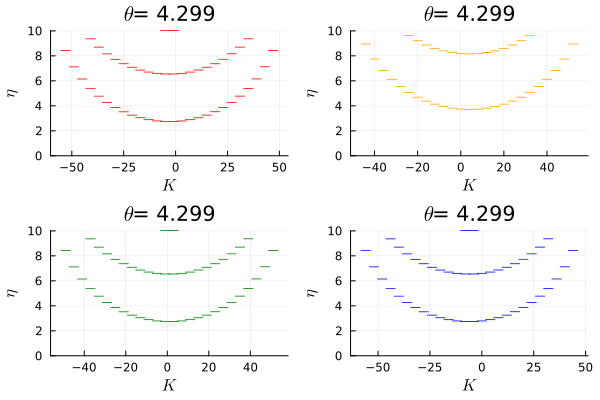

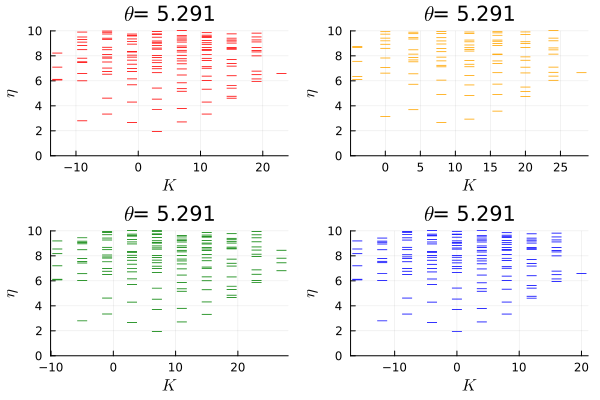

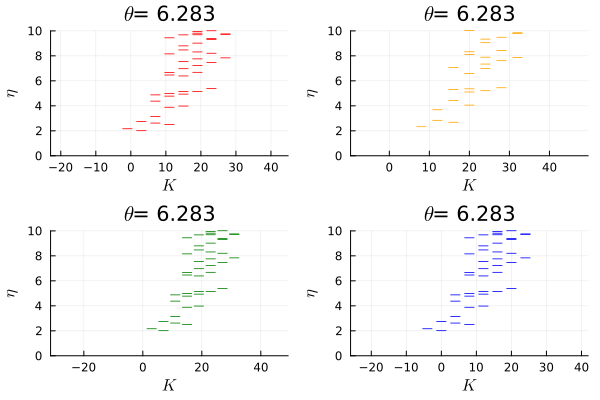

In [61]:
setIndex = [1, 10, 22, 30, 35]
# plotReprPhase(setIndex, setL[1])
plotAllEntPhase()

## Phase portrait

In [68]:
function Energy(L; c=RGB(0., 0.56, 0.), ms=5, display=true)
    
    setE = setData[1]["Energy"]
    
    # setE = broadckast(abs, setE)
    @show setE

    fig= plot()

    scatter!(fig, setθ, setE, label="Energy",legend=:bottomleft, marker=:circle, markersize=ms, color=c, xtick=pitick(0, 2π, 4; mode=:latex))
    xlabel!(fig, L"\theta")
    ylabel!(fig, L"E")
    # title!(fig, L"Energy")
    #vline!([n*pi/4 for n=3:4:8])
    
    
    namesave = "FiguresNew/Energy_Ly$(L)_chi$(χ)_tmin$(first(setθ))_tmax$(last(setθ))_type$(typeInt)"
    Plots.png(fig, namesave)
    Plots.svg(fig, namesave)
    Plots.pdf(fig, namesave)
    
    display && display(fig)
    return fig
end


function Entropy(L; c= RGB(0., 0.56, 0.), ms=5, display=true)
    
    setE = setData[1]["Entropy"]

    fig= plot()

    scatter!(fig, setθ, setE, label=L"$\mathrm{Entropy}$",legend=:bottom, marker=:circle, markersize=ms, color=c, xtick=pitick(0, 2π, 4; mode=:latex))
    xlabel!(fig, L"\theta")
    ylabel!(fig, L"S")
    #title!(fig, L"Entropy")
    #vline!([n*pi/4 for n=3:4:8])
    
    
    namesave = "FiguresNew/Entropy_Ly$(L)_chi$(χ)_tmin$(first(setθ))_tmax$(last(setθ))_type$(typeInt)"
    Plots.png(fig, namesave)
    Plots.svg(fig, namesave)
    Plots.pdf(fig, namesave)
    
    display && display(fig)
    return fig
end



function Fidelity(L::Float64; c=RGB(0., 0.56, 0.), ms=5, display=true)
    Newsetθ, setFi = Fidelity(setData[1]["Psi"], setθ)


    fig = scatter(Newsetθ, setFi, label="Fidelity", marker=:diamond, legend=:bottom, markersize=ms,  color=c, xtick=pitick(0, 2π, 4; mode=:latex))
    xlabel!(L"$\theta$")
    ylabel!(L"$\langle \psi(\theta)| \psi(\theta + \delta \theta)\rangle$")
    # title!(L"Fidelty")
    display && display(fig)

    namesave = "FiguresNew/Fidelity_Ly$(L)_chi$(χ)_tmin$(first(setθ))_tmax$(last(setθ))_type$(typeInt)"
    Plots.png(fig, namesave)
    Plots.svg(fig, namesave)
    Plots.pdf(fig, namesave)

    return fig
end

Fidelity (generic function with 2 methods)

In [78]:
ms = 4.5
p = [Energy(setL[1]; ms=ms, display=false), Entropy(setL[1]; ms=ms, display=false), Fidelity(setL[1]; ms=ms, display=false)];

setE = Any[-0.499998332593075, -0.4126500213065071, -0.34415144029346145, -0.29869997917522595, -0.27546244761206967, -0.281450153938793, -0.31406994573607205, -0.5974971338160218, -1.0165176998516132, -1.379565565366981, -1.6472988502361081, -1.7907040468380706, -1.7942419390024127, -1.6575284132695332, -1.3953790071167333, -1.0362010789266656, -0.8101682828545129, -0.698734862418855, -0.5983362216578954, -0.499998332593133]


In [79]:
l = @layout [a; b; c]
figUn = plot(p..., layout=(3,1), size=(800, 600))
# figUn[:plot_title] = 

namesave = "FiguresNew/AllComb_Ly$(setL[1])_chi$(χ)_tmin$(first(setθ))_tmax$(last(setθ))_type$(typeInt)"
Plots.png(figUn, namesave)
Plots.svg(figUn, namesave)
Plots.pdf(figUn, namesave)

display(figUn)


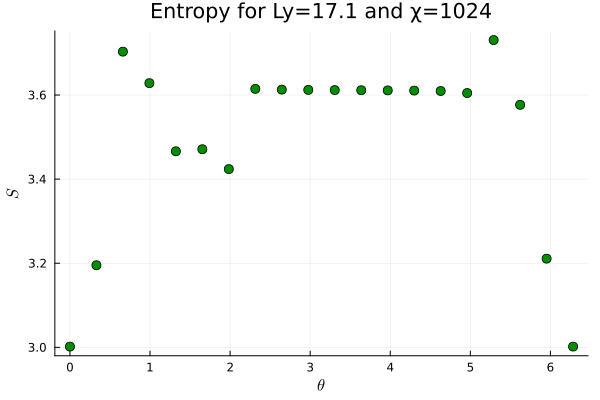

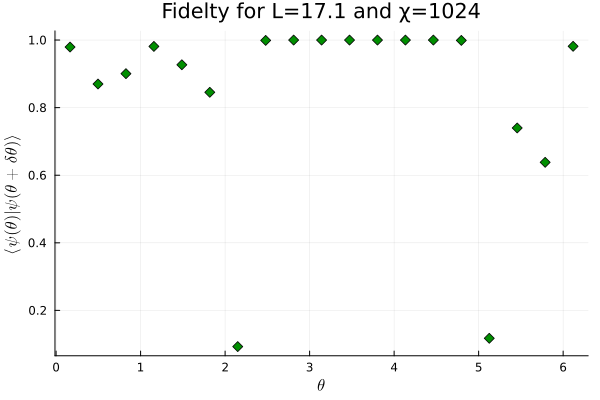

setE = [0.499998332593075, 0.4126500213065071, 0.34415144029346145, 0.29869997917522595, 0.27546244761206967, 0.281450153938793, 0.31406994573607205, 0.5974971338160218, 1.0165176998516132, 1.379565565366981, 1.6472988502361081, 1.7907040468380706, 1.7942419390024127, 1.6575284132695332, 1.3953790071167333, 1.0362010789266656, 0.8101682828545129, 0.698734862418855, 0.5983362216578954, 0.499998332593133]


"FiguresNew\\Fidelity_Ly17.1_chi1024_tmin0.0_tmax6.283185307179586_type2b_3b.pdf"

In [37]:
Energy(setL[1])
Entropy(setL[1])
Fidelity(setL[1])